# Brain Cancer MRI Images Classification

Cancer is the second leading cause of death after cardiovascular diseases. Out of all types of cancer, brain cancer has the lowest survival rate. Brain tumors can have different types depending on several factors such as the shape, texture, and location of the tumor (e.g., Acoustic Neuroma, Meningioma, Pituitary, Glioma, CNS Lymphoma . . . etc). In clinical practice, the incident rates of Glioma, Meningioma, and Pituitary tumors are approximately 45%, 15%, and 15%, respectively, among all brain tumors. Proper diagnosis of the tumor type enables the doctor to make the correct treatment choice and help save the patient’s life.


Currently, anomaly detection through MRI is manual mostly and clinicians have to spend a lot of time to detect and segment the tumor for treatment and surgical purpose. This manual technique is also prone to errors and can compromise life. Also, diversity of Tumor types, makes the detection more difficult due to the complex structure of the brain. In order to resolve these issues, studies have started to focus on various machine learning and Deep Learning techniques for computer-based tumor detection and segmentation.


 [This paper](https://www.sciencedirect.com/science/article/abs/pii/S0895611121000896?via%3Dihub) reviews different papers that tried to do the task of brain cancer MRI image classification. In this homework, we will implement and compare some of these methods.

First, import all the libraries you may need here:

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
from PIL import Image
from google.colab import drive
import os
import keras
import tensorflow as tf
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import Model, layers
from google.colab import drive
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator



## 1. Load Data (5 pt)

We have a dataset of 3064 T1-weighted contrast-enhanced MRI images of 3 brain tumor types (Meningiomas, Gliomas, and Pituitary tumors). You are supposed to download and unzip the [data](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5).

We suggest loading all of the data in one folder in google drive.

In [ ]:
!wget https://figshare.com/ndownloader/articles/1512427/versions/5
!unzip 5 -d /content/
!rm 5
!mkdir data
!unzip /content/brainTumorDataPublic_1-766.zip -d /content/data
!unzip /content/brainTumorDataPublic_767-1532.zip -d /content/data
!unzip /content/brainTumorDataPublic_1533-2298.zip -d /content/data
!unzip /content/brainTumorDataPublic_2299-3064.zip -d /content/data

## 2. Visualize some Images (7 pt)

In this part, we want to show 2 random MRI images from each category in the dataset. As we have 3 types of tumors, we should have 6 images in the output.

In this dataset, the images are in matlab format and each image is stored as a struct that includes tumorMask, tumorBorder, image, PID (PatientID), label. The h5py library is used to read the photos in the code section. Using this library, we read the dataset images that are in mat format.

 Images are labeled this way in .mat files:

Label 1: meningioma

Label 2: glioma

Label 3: pituitary

In [3]:
!pip install hdf5storage
import pandas as pd 
import hdf5storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 


In [4]:
DATA_PATH = "/content/data/"
files = os.listdir(DATA_PATH)

df = pd.DataFrame(columns = ['image', 'label', 'PID', 'filename'])
max_gray_level = 1
for f in files:  
    mat_file = hdf5storage.loadmat(DATA_PATH + f)['cjdata'][0]
    image = cv2.normalize(np.array(mat_file[2]), dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # image = np.array(mat_file[2], dtype=np.uint16)
    label = int(mat_file[0])
    PID = mat_file[1][0][0]
    filename = f
    df = df.append({'image':image, 'label':label, 'PID':PID, 'filename':f}, ignore_index = True)
df

,image,label,PID,filename
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,107946,563.mat
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,111785,1244.mat
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,MR040240C,2513.mat
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,105936,710.mat
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,112847,1261.mat
...,...,...,...,...
3059,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,98992,1439.mat
3060,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,MR029209G,2223.mat
3061,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,MR051644B,2961.mat
3062,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,MR056144,2110.mat


In [5]:
len(df.PID.unique())

233

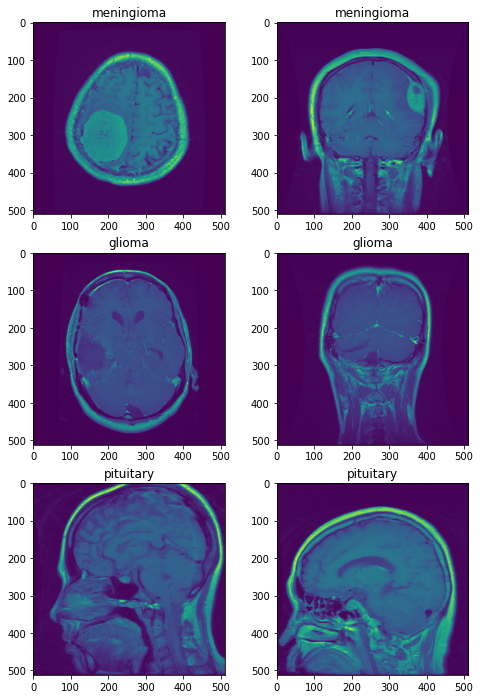

In [6]:
f, axarr = plt.subplots(3,2, figsize=(8,12))
axarr[0,0].set_title("meningioma")
axarr[0,1].set_title("meningioma")
axarr[0,0].imshow(df[df['label']==1]['image'].sample().values[0])
axarr[0,1].imshow(df[df['label']==1]['image'].sample().values[0])

axarr[1,0].set_title("glioma")
axarr[1,1].set_title("glioma")
axarr[1,0].imshow(df[df['label']==2]['image'].sample().values[0])
axarr[1,1].imshow(df[df['label']==2]['image'].sample().values[0])

axarr[2,0].set_title("pituitary")
axarr[2,1].set_title("pituitary")
axarr[2,0].imshow(df[df['label']==3]['image'].sample().values[0])
axarr[2,1].imshow(df[df['label']==3]['image'].sample().values[0])


## Split images to validation and train (10 pt)

Now, we want to save images in 3 different folders. Each folder should contain MRI images of one tumor type.

Then you should split data to train and validation. 80% of the data should be train and the rest should be validation.


In [7]:
!rm -r data_dir

rm: cannot remove 'data_dir': No such file or directory


In [8]:

def create_images(df, path):
    for index, row in df.iterrows():
        img = row['image']
        if row['label'] == 1:
            cv2.imwrite(img=img, filename=path+"/meningioma/"+row['filename'][:-3]+"png")
        elif row['label'] == 2:
            cv2.imwrite(img=img, filename=path+"/glioma/"+row['filename'][:-3]+"png")
        else:
            cv2.imwrite(img=img, filename=path+"/pituitary/"+row['filename'][:-3]+"png")


os.makedirs('/content/data_dir/train/meningioma/')
os.makedirs('/content/data_dir/train/glioma/')
os.makedirs('/content/data_dir/train/pituitary/')

os.makedirs('/content/data_dir/val/meningioma/')
os.makedirs('/content/data_dir/val/glioma/')
os.makedirs('/content/data_dir/val/pituitary/')

train, validation = train_test_split(df, test_size=0.2)

create_images(validation, "/content/data_dir/val/")
create_images(train, "/content/data_dir/train/")



### Data Preprocessing (15 pt)

Medical images datasets are smaller in size than the datasets available in other domains due to their limitations. One way to overcome the problem of lack of sufficient amount of training data is data augmentation.

There are many type of manipulations that we can use for this target. Here are a list of some augmentation techniques that you can use in this task:

Horizontal and vertical flips

Rotation

Zooming

Shifting

Shearing

Brightness

ZCA whitening

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/data_dir/train/"
val_dir =  "/content/data_dir/val/"
BATCH_SIZE = 64
IMAGE_HEIGHT = IMAGE_WIDTH = 224
#complete this function for augmentation perpose
train_data = ImageDataGenerator(
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        rotation_range=10,
        # zca_whitening=True,
        brightness_range=[0.2, 1.2],
        preprocessing_function=preprocess_input
        )
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224),batch_size=BATCH_SIZE)
val_data = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
validdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224),batch_size=BATCH_SIZE)

Found 2451 images belonging to 3 classes.
Found 613 images belonging to 3 classes.


## Implementing 3 Different Classification Models

Now we want to design models for MRI image classification. Models that we want to use are these:

1- ResNet50

2- AlexNet

3- Multi-layer perceptron

### ResNet Model Design, image level (20pt)

Now it's time to create the model. Here we use Residual Network architecture composed of 50 layers for our model. Set the optimizer to 'Adam' and learning rate to '0.0003' for 200 epoches. You can change settings like LR untill getting better performance.


In this task we consentrate on the content of [this paper](https://doi.org/10.1016/j.artmed.2019.101779).

In [12]:
# weights='imagenet',
ResNet_model = Sequential()
pretrained = ResNet50(weights='imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
pretrained.trainable = False
ResNet_model.add(pretrained)
ResNet_model.add(GlobalAveragePooling2D())
ResNet_model.add(Dense(128, activation='relu'))
ResNet_model.add(Dense(64, activation='relu'))
ResNet_model.add(Dense(3, activation='softmax'))


94765736/94765736 [==============================] - 5s 0us/step


In [13]:
ResNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 23,858,435
Trainable params: 270,723
Non-trainable params: 23,587,712
______________________________________

### Train the ResNet50 model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.


In [14]:
from sklearn.metrics import f1_score

from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [15]:
!pip install tensorflow-addons


import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(3,'macro')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 33.2 MB/s 


In [16]:
initial_learning_rate = 0.0003

opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
ResNet_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy',f1,tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = ResNet_model.fit(traindata, epochs=30, validation_data=validdata)

Epoch 1/30
39/39 [==============================] - 53s 1s/step - loss: 0.6700 - accuracy: 0.7038 - f1_score: 0.6532 - precision: 0.7832 - recall: 0.6042 - val_loss: 0.3979 - val_accuracy: 0.8222 - val_f1_score: 0.7953 - val_precision: 0.8446 - val_recall: 0.7977
Epoch 2/30
39/39 [==============================] - 39s 991ms/step - loss: 0.4160 - accuracy: 0.8258 - f1_score: 0.8057 - precision: 0.8510 - recall: 0.7972 - val_loss: 0.4551 - val_accuracy: 0.8108 - val_f1_score: 0.7301 - val_precision: 0.8339 - val_recall: 0.7945
Epoch 3/30
39/39 [==============================] - 39s 999ms/step - loss: 0.3768 - accuracy: 0.8535 - f1_score: 0.8348 - precision: 0.8704 - recall: 0.8303 - val_loss: 0.3336 - val_accuracy: 0.8630 - val_f1_score: 0.8308 - val_precision: 0.8708 - val_recall: 0.8467
Epoch 4/30
39/39 [==============================] - 40s 1s/step - loss: 0.3448 - accuracy: 0.8633 - f1_score: 0.8461 - precision: 0.8810 - recall: 0.8486 - val_loss: 0.3200 - val_accuracy: 0.8630 - val_

###Loss and accuracy diagrams for ResNet50 (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

In this model I used imagenet pretrained wieghts for initial point. Our final results are:
loss: 0.1531 - accuracy: 0.9457 - f1_score: 0.9384 - precision: 0.9494 - recall: 0.9421 - val_loss: 0.1967 - val_accuracy: 0.9250 - val_f1_score: 0.9156 - val_precision: 0.9260 - val_recall: 0.9184

The curves above show that our validation loss and accuracy are generally decreasing and increasing.


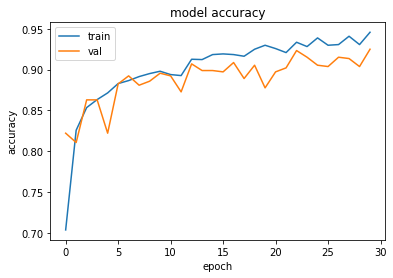

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

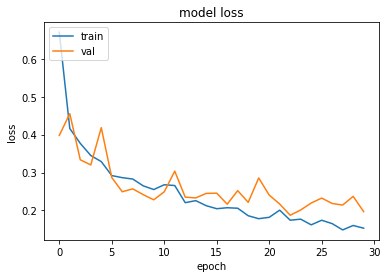

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###ResNet Model, Patient level (30 pt)


Here we want to repeat ResNet model in a different way. You should do all the steps again with a difference in spliting the data. In patient level you should pay attention that all the images from a patient should be either in train or validation.

So, do the spliting part of data with considering this point and then do all the steps again (design the model, train the model, plot accuracy and loss diagrams).


How different are the results? 
In this method our result are worse than the previous method and it is the result of our policy agraints data, because in this method the model is being test with new datas that has not been seen yet in the model.

Which method do yo think is better? Which results are more reliable? Image level method or patient level method?
Patient lavel approach, the second approach, is more reliable, because in the first approach the higher accuracy in test set is the result of seeing some data from the same patient in train set and it could be misleading.


In [19]:
all_patients = df.PID.unique()
train, validation = train_test_split(all_patients, test_size=0.2)
len(train)

186

In [20]:
os.makedirs('/content/patient/train/meningioma/')
os.makedirs('/content/patient/train/glioma/')
os.makedirs('/content/patient/train/pituitary/')

os.makedirs('/content/patient/val/meningioma/')
os.makedirs('/content/patient/val/glioma/')
os.makedirs('/content/patient/val/pituitary/')

def create_images(df, path, patients):
    for index, row in df.iterrows():
        if row['PID'] not in patients:
            continue
        img = row['image']
        if row['label'] == 1:
            cv2.imwrite(img=img, filename=path+"/meningioma/"+row['filename'][:-3]+"png")
        elif row['label'] == 2:
            cv2.imwrite(img=img, filename=path+"/glioma/"+row['filename'][:-3]+"png")
        else:
            cv2.imwrite(img=img, filename=path+"/pituitary/"+row['filename'][:-3]+"png")

create_images (df, '/content/patient/train/', train)
create_images (df, '/content/patient/val/', validation)


In [21]:

train_dir = "/content/patient/train/"
val_dir =  "/content/patient/val/"
BATCH_SIZE = 64
IMAGE_HEIGHT = IMAGE_WIDTH = 224

train_data = ImageDataGenerator(
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        rotation_range=10,
        # zca_whitening=True,
        brightness_range=[0.2, 1.2],
        preprocessing_function=preprocess_input
        )
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224),batch_size=BATCH_SIZE)
val_data = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
validdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224),batch_size=BATCH_SIZE)

ResNet_model = Sequential()
pretrained = ResNet50(weights='imagenet', include_top = False, input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
pretrained.trainable = False
ResNet_model.add(pretrained)
ResNet_model.add(GlobalAveragePooling2D())
ResNet_model.add(Dense(128, activation='relu'))
ResNet_model.add(Dense(64, activation='relu'))
ResNet_model.add(Dense(3, activation='softmax'))

Found 2430 images belonging to 3 classes.
Found 634 images belonging to 3 classes.


In [22]:
initial_learning_rate = 0.0003

opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
ResNet_model.compile(optimizer = opt, loss = 'categorical_crossentropy',
                     metrics = ['accuracy', f1, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = ResNet_model.fit(traindata, epochs=30, validation_data=validdata)

Epoch 1/30
38/38 [==============================] - 45s 1s/step - loss: 0.7579 - accuracy: 0.6794 - f1_score: 0.6921 - precision_1: 0.7763 - recall_1: 0.5412 - val_loss: 0.5476 - val_accuracy: 0.7823 - val_f1_score: 0.7805 - val_precision_1: 0.8138 - val_recall_1: 0.7240
Epoch 2/30
38/38 [==============================] - 39s 1s/step - loss: 0.4239 - accuracy: 0.8453 - f1_score: 0.8188 - precision_1: 0.8720 - recall_1: 0.8074 - val_loss: 0.4859 - val_accuracy: 0.7760 - val_f1_score: 0.7648 - val_precision_1: 0.8095 - val_recall_1: 0.7508
Epoch 3/30
38/38 [==============================] - 39s 1s/step - loss: 0.3601 - accuracy: 0.8584 - f1_score: 0.8349 - precision_1: 0.8753 - recall_1: 0.8346 - val_loss: 0.4674 - val_accuracy: 0.7776 - val_f1_score: 0.7587 - val_precision_1: 0.8104 - val_recall_1: 0.7618
Epoch 4/30
38/38 [==============================] - 38s 1s/step - loss: 0.3407 - accuracy: 0.8617 - f1_score: 0.8370 - precision_1: 0.8767 - recall_1: 0.8399 - val_loss: 0.4502 - val_a

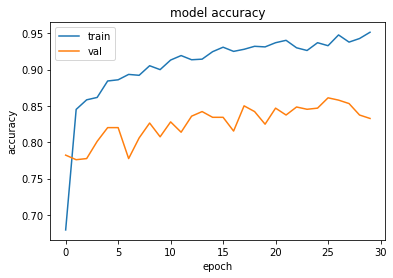

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

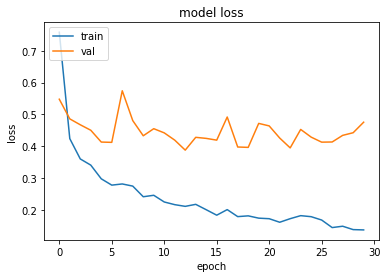

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 1. AlexNet Model Design (20 pt)

Now we want to test another model. We will use AlexNet here.

Run it for 100 epoches. You can change settings to get better performance.

set optimizer = 'Adam' and loss = 'categorical_crossentropy'.



In [25]:
AlexNet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

In [26]:
AlexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                      

In [27]:
!pip install tensorflow-addons

import tensorflow_addons as tfa 

f1 = tfa.metrics.F1Score(36,'micro' or 'macro')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Train the AlexNet model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.

In [28]:
initial_learning_rate = 0.0003

opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
AlexNet_model.compile(optimizer = opt, loss = 'categorical_crossentropy',
                      metrics = ['accuracy',f1, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = AlexNet_model.fit(traindata, epochs=100, validation_data=validdata)

Epoch 1/100
38/38 [==============================] - 41s 999ms/step - loss: 2.8541 - accuracy: 0.4572 - f1_score: 0.4572 - precision_2: 0.4632 - recall_2: 0.4321 - val_loss: 51.2123 - val_accuracy: 0.4338 - val_f1_score: 0.4338 - val_precision_2: 0.4338 - val_recall_2: 0.4338
Epoch 2/100
38/38 [==============================] - 36s 954ms/step - loss: 1.6817 - accuracy: 0.5004 - f1_score: 0.5004 - precision_2: 0.5126 - recall_2: 0.4514 - val_loss: 9.0927 - val_accuracy: 0.2839 - val_f1_score: 0.2839 - val_precision_2: 0.2839 - val_recall_2: 0.2839
Epoch 3/100
38/38 [==============================] - 37s 968ms/step - loss: 1.3515 - accuracy: 0.5132 - f1_score: 0.5132 - precision_2: 0.5402 - recall_2: 0.4502 - val_loss: 1.5826 - val_accuracy: 0.4527 - val_f1_score: 0.4527 - val_precision_2: 0.4629 - val_recall_2: 0.4432
Epoch 4/100
38/38 [==============================] - 36s 948ms/step - loss: 1.1609 - accuracy: 0.5671 - f1_score: 0.5671 - precision_2: 0.5982 - recall_2: 0.5000 - val_los

###Loss and accuracy diagrams for AlexNet (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.
the best result is in epoch 91 and the results are:
loss: 0.1290 - accuracy: 0.9556 - f1_score: 0.9556 - precision_2: 0.9597 - recall_2: 0.9506 - val_loss: 0.3487 - val_accuracy: 0.8707 - val_f1_score: 0.8707 - val_precision_2: 0.8778 - val_recall_2: 0.8612

Generally the validation accuracy and train accuracy are both increasing, but in validation accuracy we have many jumps. Therefore, with an appropriate learning rate and schduler and more epochs of training we could get better results.


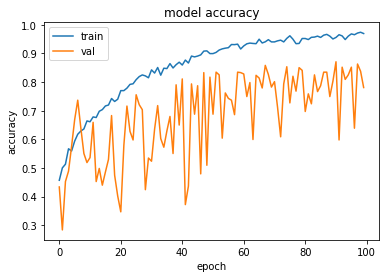

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

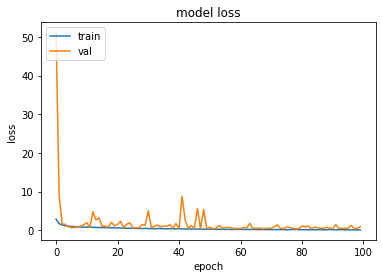

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Design the Multi-Layer Perceptron model (20 pt)

We want to implement a Multi layer perceptron deep network to classify our dataset too.

Do the steps as you did in other models.

In [31]:
image_size = 128
batch_size = 32

train_dir = "/content/data_dir/train/"
val_dir =  "/content/data_dir/val/"
#complete this function for augmentation perpose
train_data = ImageDataGenerator(
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        rotation_range=10,
        preprocessing_function=preprocess_input
        )
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(image_size,image_size),batch_size=batch_size)
val_data = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
validdata = val_data.flow_from_directory(directory=val_dir, target_size=(image_size,image_size),batch_size=batch_size)

MLP_model = keras.models.Sequential([
    Flatten(input_shape=(128,128,3)),
    Dense(256 , activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

Found 2451 images belonging to 3 classes.
Found 613 images belonging to 3 classes.


In [32]:
MLP_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               12583168  
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 12,599,811
Trainable params: 12,599,811
Non-trainable params: 0
_________________________________________________________________


###Train the model (10pt)

In [33]:
initial_learning_rate = 0.0003

opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
MLP_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy',f1, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = MLP_model.fit(traindata, epochs=20, validation_data=validdata)

Epoch 1/20
77/77 [==============================] - 18s 224ms/step - loss: 317.2455 - accuracy: 0.4774 - f1_score: 0.5397 - precision_3: 0.4774 - recall_3: 0.4774 - val_loss: 49.2827 - val_accuracy: 0.6330 - val_f1_score: 0.6330 - val_precision_3: 0.6330 - val_recall_3: 0.6330
Epoch 2/20
77/77 [==============================] - 17s 219ms/step - loss: 168.5845 - accuracy: 0.4802 - f1_score: 0.4802 - precision_3: 0.4802 - recall_3: 0.4802 - val_loss: 136.7936 - val_accuracy: 0.4845 - val_f1_score: 0.4845 - val_precision_3: 0.4845 - val_recall_3: 0.4845
Epoch 3/20
77/77 [==============================] - 17s 216ms/step - loss: 148.3507 - accuracy: 0.5153 - f1_score: 0.5153 - precision_3: 0.5153 - recall_3: 0.5153 - val_loss: 114.6579 - val_accuracy: 0.5579 - val_f1_score: 0.5579 - val_precision_3: 0.5579 - val_recall_3: 0.5579
Epoch 4/20
77/77 [==============================] - 17s 216ms/step - loss: 121.8850 - accuracy: 0.5300 - f1_score: 0.5300 - precision_3: 0.5300 - recall_3: 0.5300 -

###Loss and accuracy diagrams for multi-layer perceptron (10 pt)


This model has a poor result becuase we do not use concolution layers to downsample our features to get rich representations.
Also if we add layers number of parameters will increase too much and it is not feasible.

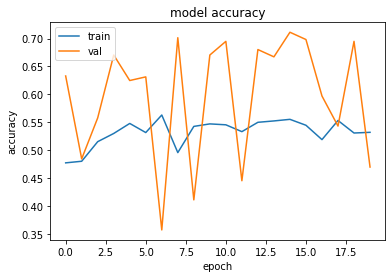

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

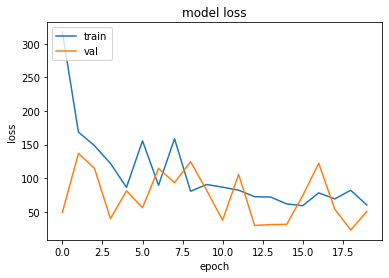

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####Now answer these questions:

1- How close are your answers to those in the paper? We are not close to the results of paper.

2- Why do you think they aren't close if they aren't? Having more appropriate preprocessing methods can be helpful. Inaddition, here we use tensorflow image data generator which does not support 12-bit gray level images, so we have information loss.

3- What suggestions do you have for improving any of these methods? Using preprocessing methods and adding batch normalization could help the model. Also finetuning on resnet could leads to better results.

4- Compare the results from these 3 models. How would you rate each method in terms of its effectiveness? Transfer learning with resnet50 has the best result between these three models. It is trained faster than other methods. AlexNet also could be a effective approach but it has more parameters than resnet so it takes more time to train than resnet.

5- Can we trust our answer for any MRI image of a patient? Answer the question in detail.
We did not interpret our model, as a result we can't trust these models. Maybe our model just learned some correlated features in dataset and the predictions are not reliable. Also, our dataset may not be general and it could have some biases so we can't predict other MRI images from different datasets and the accuracy on them will be much less the reported accuracy.